In [18]:
import torch
import torchvision.transforms as transforms              
from torchvision.datasets import CIFAR10      
from torch.utils.data import DataLoader
from src.temperature_scaling import ModelWithTemperature
from src.inception import inception_v3


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dict_path = "C:\\Users\\jiayang\\ipynb\\trainedModel\\Inception_CIFAR10.pth"
model = inception_v3(pretrained=True, dict_path=dict_path).to(device)
model.eval()

# preprocess the images from CIFAR10
data_transform = transforms.Compose([
    transforms.ToTensor(),         
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  
])

# load data set for training
pre_train_dataset = CIFAR10(root="../../data", train=False, download=True,transform=data_transform)
pre_test_dataset = CIFAR10(root="../../data", train=False, download=True, transform=data_transform)

train_loader = DataLoader(pre_train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(pre_test_dataset, batch_size=32, shuffle=False)

Loading weights from: C:\Users\jiayang\ipynb\trainedModel\Inception_CIFAR10.pth
Files already downloaded and verified
Files already downloaded and verified


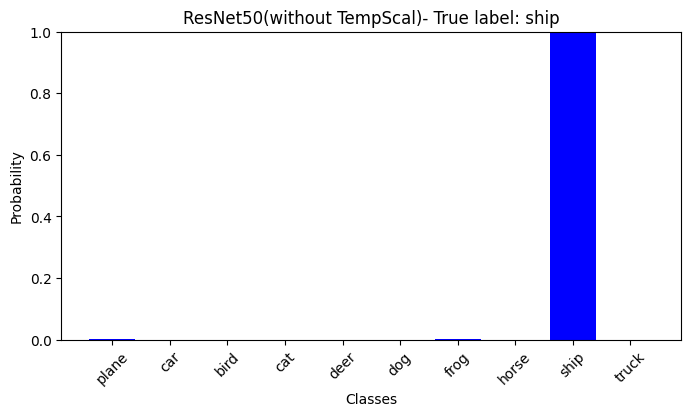

In [29]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

test_iter = iter(test_loader)
image, label = next(test_iter)
image, label = image[15].to(device), label[15].item()
model.eval()

with torch.no_grad():
    logits = model(image.unsqueeze(0))  
    probabilities = F.softmax(logits, dim=1).cpu().numpy().flatten() 

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(8, 4))
plt.bar(classes, probabilities, color='blue')
plt.xlabel("Classes")
plt.ylabel("Probability")
plt.title(f"ResNet50(without TempScal)- True label: {classes[label]}")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

Before temperature - NLL: 0.316, ECE: 0.048
Optimal temperature: 5.130
After temperature - NLL: 0.602, ECE: 0.294


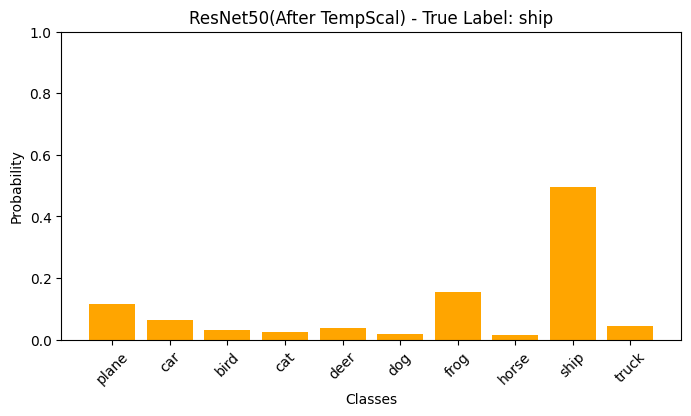

In [31]:
model_with_temp = ModelWithTemperature(model, temperature = 5.2).to(device)
model_with_temp.set_temperature(train_loader)

model_with_temp.eval()
with torch.no_grad():
    logits = model_with_temp(image.unsqueeze(0)) 
    probabilities_temp = F.softmax(logits, dim=1).cpu().numpy().flatten() 

plt.figure(figsize=(8, 4))
plt.bar(classes, probabilities_temp, color='orange')
plt.xlabel("Classes")
plt.ylabel("Probability")
plt.title(f"ResNet50(After TempScal) - True Label: {classes[label]}")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()